<a href="https://colab.research.google.com/github/NhatTruong200403/Data_Captcha/blob/main/Captcha(LSTM%2BCNN)_ipynp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mô hình nhận diện captcha từ hình ảnh.
Nhóm thực hiện gồm:
+ Nguyễn Trần Nhật Trường 2180604468
+ Nguyễn Thành Kỷ 2180600741

Mô tả: Cách triển khai mô hình OCR bằng cách sử dụng LSTM, CNN, RNN và CTC.

# Giới thiệu

Để đọc được các ký tự trong ảnh CAPTCHA, cần áp dụng các kỹ thuật nhận dạng văn bản. Mục tiêu của bài toán này là phát triển một hệ thống có thể phát hiện và trích xuất chính xác các ký tự từ hình ảnh CAPTCHA. Đây là một nhiệm vụ đầy thách thức vì CAPTCHA được thiết kế đặc biệt để máy khó đọc nhằm ngăn chặn các bot tự động truy cập vào các trang web. Để giải quyết vấn đề này, chúng ta sẽ cần sử dụng kết hợp các kỹ thuật xử lý hình ảnh, nhận dạng mẫu và học máy.


## Cài đặt các thư viện

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Tải tập dữ liệu về

In [ ]:
! rm -rf *

!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qqu captcha_images_v2.zip

!curl -LO https://github.com/NhatTruong200403/Data_Captcha/raw/main/captcha_images_v2.zip
!mkdir -p captcha_images_v3; cd captcha_images_v3; unzip -qqu ../captcha_images_v2.zip; cd ..


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  9236k      0 --:--:-- --:--:-- --:--:-- 9236k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2762k  100 2762k    0     0  2669k      0  0:00:01  0:00:01 --:--:-- 2669k


Tập dữ liệu chứa 1040 tệp hình ảnh xác thực dưới dạng hình ảnh png. Nhãn cho mỗi mẫu là một chuỗi, tên của tệp (trừ phần mở rộng của tệp). Chúng ta sẽ ánh xạ từng ký tự trong chuỗi thành một số nguyên để huấn luyện mô hình. Tương tự, chúng ta sẽ cần ánh xạ các dự đoán của mô hình trở lại chuỗi. Với mục đích này, chúng tôi sẽ duy trì hai từ điển, ánh xạ các ký tự thành số nguyên và số nguyên tương ứng thành ký tự.

In [ ]:

# Path to the data directory


data_dir = Path("./captcha_images_v2/")
#data_dir = Path("./captcha_images_v3/")


# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Tiền xử lý tập dữ liệu
Mô hình Machine Learning được huấn luyện dựa trên dữ liệu. Phần lớn dữ liệu trong dataset được sử dụng để huấn luyện mô hình, và phần dữ liệu này được gọi là training set.
Mặt khác, cần có một phần dữ liệu dùng để đánh giá việc “học” của mô hình, khi đó chúng ta cần đến test set. Dữ liệu trong test set phải là dữ liệu mới, chưa từng được “học” hay “thấy” bởi mô hình, và sát với dữ liệu thực tế. Test set đóng vai trò như một mẫu (sample), với tổng thể (population) là dữ liệu thực tế của bài toán đang giải quyết, hay dữ liệu trong test set có cùng “phân phối” (distribution) với dữ liệu thực tế. Do đó, kết quả của mô hình thể hiện trên test set là một thước đo tin cậy cho “hiệu năng” thực tế của mô hình.


In [ ]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def split_data(images, labels, train_size=0.9, shuffle=True):
#def split_data(images, labels, train_size=0.7, shuffle=True):

    # 1. Get the total size of the dataset
    size = len(images)
    print(size)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

#x_train = x_train[:100]
#y_train = y_train[:100]

print("Training samples:", len(x_train))
print("Validation samples:", len(x_valid))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


1040
Training samples: 936
Validation samples: 104


## Tạo đối tượng Dataset

In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Trực quan hóa dữ liệu

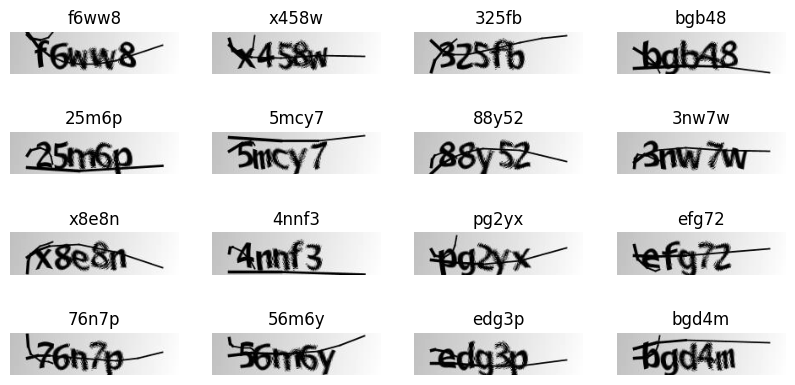

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Mô hình

In [ ]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## Huấn luyện

Epoch 1/100
59/59 [==============================] - 15s 70ms/step - loss: 19.9424 - val_loss: 16.4637
Epoch 2/100
59/59 [==============================] - 3s 46ms/step - loss: 16.3709 - val_loss: 16.4129
Epoch 3/100
59/59 [==============================] - 3s 43ms/step - loss: 16.3566 - val_loss: 16.4032
Epoch 4/100
59/59 [==============================] - 2s 34ms/step - loss: 16.3477 - val_loss: 16.3971
Epoch 5/100
59/59 [==============================] - 3s 43ms/step - loss: 16.3420 - val_loss: 16.3925
Epoch 6/100
59/59 [==============================] - 2s 40ms/step - loss: 16.3307 - val_loss: 16.3815
Epoch 7/100
59/59 [==============================] - 2s 34ms/step - loss: 16.3161 - val_loss: 16.3709
Epoch 8/100
59/59 [==============================] - 2s 33ms/step - loss: 16.2938 - val_loss: 16.3192
Epoch 9/100
59/59 [==============================] - 2s 34ms/step - loss: 16.2477 - val_loss: 16.2302
Epoch 10/100
59/59 [==============================] - 2s 40ms/step - loss: 15.986

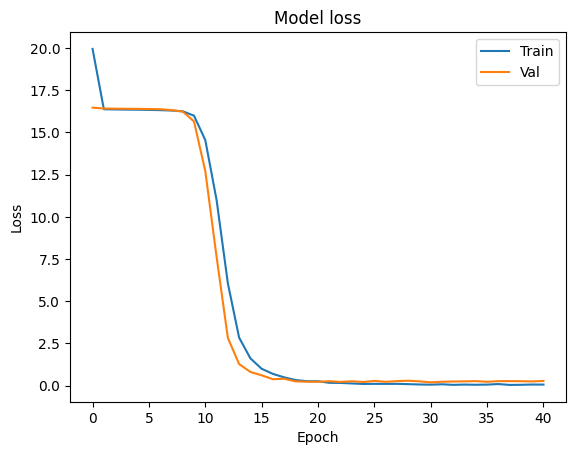

In [ ]:

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

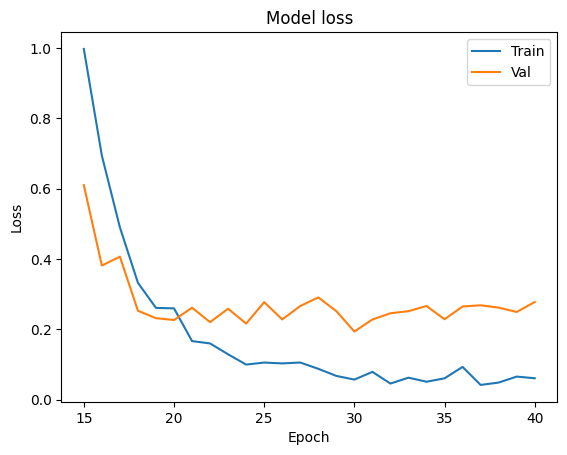

In [ ]:
start_epoch = 15
epoch_range = range(start_epoch, len(history.history['loss']))
plt.plot(epoch_range, history.history['loss'][start_epoch:])
plt.plot(epoch_range, history.history['val_loss'][start_epoch:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Dự đoán


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

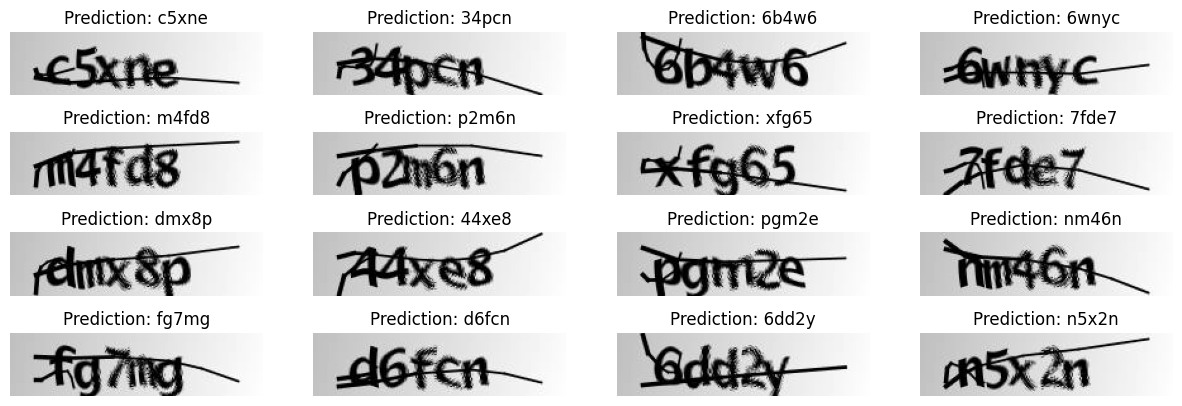

In [ ]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
cnt = 0
total = 0
for batch_idx, batch in enumerate(validation_dataset):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for i, label in enumerate(batch_labels):
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        if label == pred_texts[i]:
          cnt += 1
        total += 1
        orig_texts.append(label)
    if batch_idx == 0:
      _, ax = plt.subplots(4, 4, figsize=(15, 5))
      for i in range(len(pred_texts)):
          img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
          img = img.T
          title = f"Prediction: {pred_texts[i]}"
          ax[i // 4, i % 4].imshow(img, cmap="gray")
          ax[i // 4, i % 4].set_title(title)
          ax[i // 4, i % 4].axis("off")
print("Accuracy: {}/{} = {}".format(cnt , total, cnt / total))
plt.show()

##Biểu đồ thể hiện độ chính xác
Nếu bộ dữ liệu càng nhiều, chia tập train và tập test càng nhiều dữ liệu thì tính học và độ chính xác của mô hình càng cao.

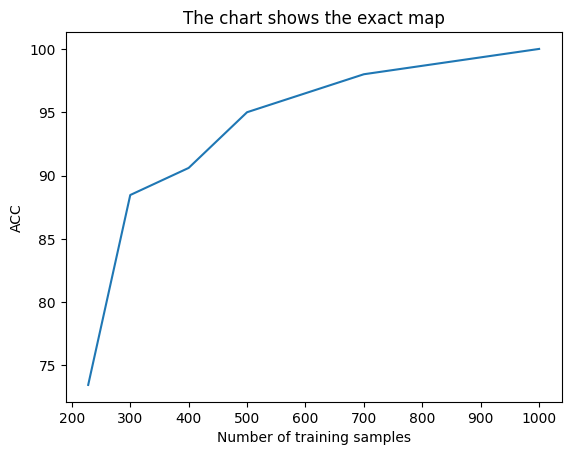

In [ ]:
experiment = [
    {'train': 228, 'acc': 73.46},
    {'train': 300, 'acc': 88.46},
    {'train': 400, 'acc': 90.6},
    {'train': 500, 'acc': 95},
    {'train': 700, 'acc': 98},
    {'train': 1000, 'acc': 100},
]
x, y = [], []
for exp in experiment:
  x.append(exp['train'])
  y.append(exp['acc'])

plt.plot(x, y)
plt.title('The chart shows the exact map')
plt.ylabel('ACC')
plt.xlabel('Number of training samples')
plt.show()